In [1]:
# Getting the data generators for the training and validation sets
import os
import sys

module_path = os.path.abspath('../utils')
print("Adding to sys.path:", module_path)
sys.path.append(module_path)

from data_prep import get_data_generators
train_gen, valid_gen, full_gen, _ = get_data_generators('../data/pokemon.csv', '../data/pokemon-img/pokemon/pokemon/', img_size=(128,128))

Adding to sys.path: c:\Users\halod\Documents\Projects\poke_classy\utils

{'bug': 0, 'dark': 1, 'dragon': 2, 'electric': 3, 'fairy': 4, 'fighting': 5, 'fire': 6, 'flying': 7, 'ghost': 8, 'grass': 9, 'ground': 10, 'ice': 11, 'normal': 12, 'poison': 13, 'psychic': 14, 'rock': 15, 'steel': 16, 'water': 17}
Found 576 validated image filenames.
Found 145 validated image filenames.
Found 721 validated image filenames.


(16, 128, 128, 3) (16, 18)


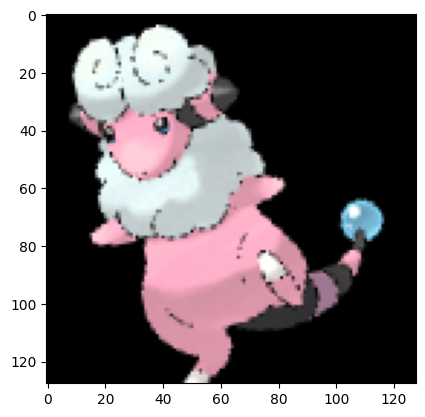

In [2]:
import matplotlib.pyplot as plt
x, y = next(train_gen)
print(x.shape, y.shape)

plt.imshow(x[2])
plt.show()

In [6]:
# defining the model based on the base model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l2

model =models.Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(18))

model.compile(
    optimizer=Adam(1e-5),
    loss=BinaryCrossentropy(from_logits=True),  # For multi-label
    metrics=[AUC(name='auc', multi_label=True), Precision(name='precision', thresholds=0.4), Recall(name='recall',thresholds=0.4)]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 124, 16)      1216      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 62, 62, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 58, 58, 32)        12832     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 29, 29, 32)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 29, 29, 32)       

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',patience=15, verbose=0
)

history = model.fit(train_gen, 
                   epochs=500, 
                   validation_data=valid_gen, 
                   callbacks=[early_stopping], 
                   verbose=1)


Epoch 1/500
36/36 [==============================] - 4s 80ms/step - loss: 0.7200 - auc: 0.5056 - precision: 0.0809 - recall: 0.1384 - val_loss: 0.6905 - val_auc: 0.4859 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/500
36/36 [==============================] - 3s 77ms/step - loss: 0.6973 - auc: 0.5164 - precision: 0.0775 - recall: 0.0738 - val_loss: 0.6859 - val_auc: 0.4961 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/500
36/36 [==============================] - 3s 72ms/step - loss: 0.6826 - auc: 0.5133 - precision: 0.0606 - recall: 0.0415 - val_loss: 0.6809 - val_auc: 0.4968 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/500
36/36 [==============================] - 3s 73ms/step - loss: 0.6724 - auc: 0.4983 - precision: 0.0761 - recall: 0.0577 - val_loss: 0.6734 - val_auc: 0.5022 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/500
36/36 [==============================] - 3s 70ms/step - loss: 0.6631 - auc: 0.4753 - precision: 0.06

46/46 - 1s - loss: 0.3888 - auc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - 963ms/epoch - 21ms/step
[0.3887782096862793, 0.5, 0.0, 0.0]
10/10 - 0s - loss: 0.3888 - auc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - 229ms/epoch - 23ms/step
[0.38879868388175964, 0.5, 0.0, 0.0]


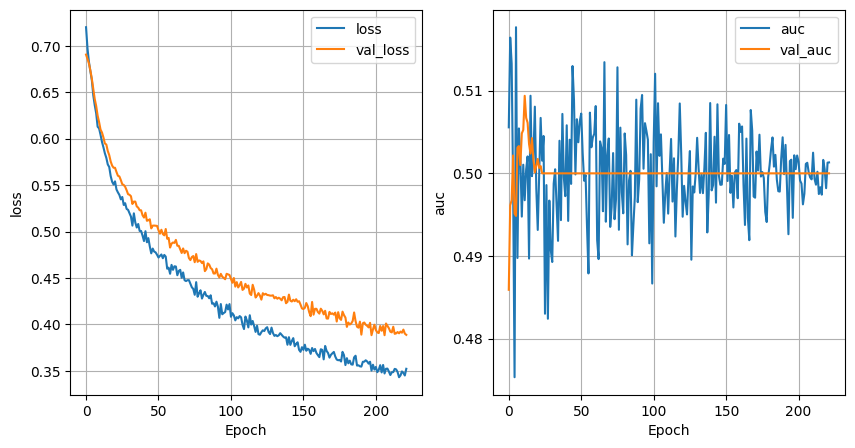

In [8]:
keys = list(history.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)


for idx, ax in enumerate(axes): 

    axes[idx].plot(history.history[keys[idx]], label=keys[idx])
    axes[idx].plot(history.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()
    axes[idx].grid(True)

print( model.evaluate(full_gen, verbose=2)); 
print( model.evaluate(valid_gen, verbose=2)); 
# print("\n\nLoss on test set {:.3},  Categorical accuracy on test set {:.3f}, AUC {:.3f}".format(test_loss, test_acc, auc))

In [62]:

model.save('../models/poke_type_(64x64,0.74auc)v2.h5')
print("✅ Model saved")

✅ Model saved
